# 01 — ML vs Deep Learning

Purpose: position neural networks within ML, and build a practical intuition for when simple models are enough vs when representation learning helps.

## Learning goals
- Distinguish *model capacity* vs *data/feature quality*.
- See why some problems are solved by linear decision boundaries and others are not.
- Understand why deep learning is usually about *learning features* from raw inputs.

## Prerequisites
- Notebook 00 conventions.
- Basic algebra with vectors (dot products).
- Comfort with plotting.

## Key ideas
- If the right feature representation makes the problem linearly separable, a simple model can be sufficient.
- Deep nets often matter when the representation is unknown or expensive to hand-engineer.
- More capacity without enough signal/data tends to overfit.

## Minimal theory
- A linear classifier uses `score = xW + b` and predicts with a threshold.
- Some datasets (e.g., XOR) are not separable by a single line in the original space.
- A non-linear feature map can convert an unsolved problem into a solvable one.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
rng = np.random.default_rng(SEED)

def make_xor(N=400, noise=0.25, rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    x = rng.uniform(-1, 1, size=(N, 2))
    y = ((x[:, 0] > 0) ^ (x[:, 1] > 0)).astype(float).reshape(-1, 1)
    x = x + rng.normal(0, noise, size=x.shape)
    return x, y

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# Binary Cross Entropy Loss
def bce_loss(a, y, eps=1e-12):
    a = np.clip(a, eps, 1 - eps)
    return -np.mean(y*np.log(a) + (1-y)*np.log(1-a))

def train_linear_logreg(x, y, lr=0.5, steps=400):
    N, D = x.shape
    W = rng.normal(0, 0.1, size=(D, 1))
    b = np.zeros((1, 1))
    losses = []
    for _ in range(steps):
        z = x @ W + b
        a = sigmoid(z)
        L = bce_loss(a, y)
        # gradients
        dz = (a - y) / N
        dW = x.T @ dz
        db = np.sum(dz, axis=0, keepdims=True)
        W -= lr * dW
        b -= lr * db
        losses.append(L)
    return W, b, np.array(losses)

x, y = make_xor(N=500, noise=0.20, rng=rng)
print('x shape:', x.shape)
print('y shape:', y.shape)

W, b, losses = train_linear_logreg(x, y, lr=0.8, steps=600)
print('W shape:', W.shape, 'b shape:', b.shape)
print('Final loss:', losses[-1])

x shape: (500, 2)
y shape: (500, 1)
W shape: (2, 1) b shape: (1, 1)
Final loss: 0.6925623314350842


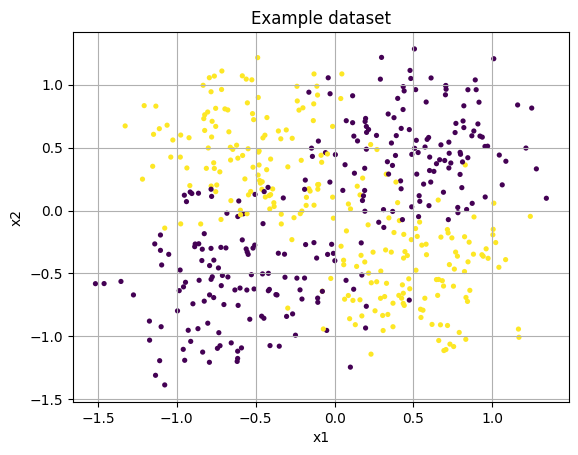

In [19]:
plt.scatter(x[:,0], x[:,1], c=y[:,0], s=14, edgecolors='none')
plt.title("Example dataset")
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.show()


## Step-by-step experiments
1. Fit a linear classifier to XOR-like data (expect failure).
2. Add a simple engineered feature `x1*x2` and refit (expect improvement).
3. Compare decision boundaries and loss curves.

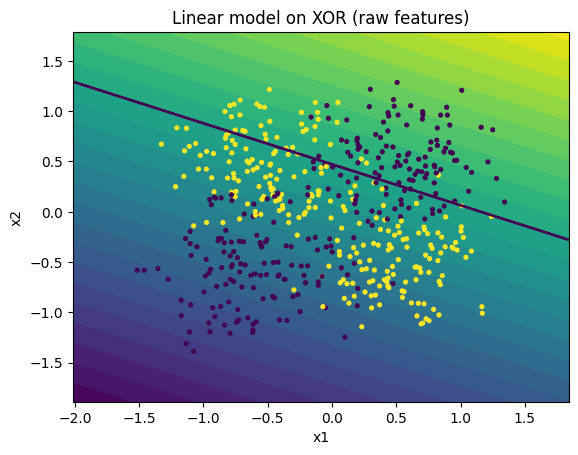

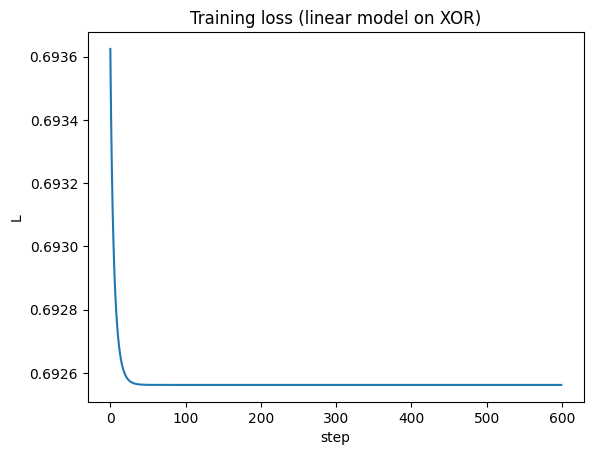

In [16]:
def plot_decision_boundary_linear(x, y, W, b, title, use_grid_product=False, plot_decision_boundary=True):
    x1_min, x1_max = x[:,0].min()-0.5, x[:,0].max()+0.5
    x2_min, x2_max = x[:,1].min()-0.5, x[:,1].max()+0.5
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200), np.linspace(x2_min, x2_max, 200))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    if use_grid_product:
        grid_eng = np.concatenate([grid, (grid[:,0:1]*grid[:,1:2])], axis=1)
    else:
        grid_eng = grid
    a = sigmoid(grid_eng @ W + b).reshape(xx1.shape)
    plt.figure()
    plt.contourf(xx1, xx2, a, levels=30)
    if plot_decision_boundary:
        plt.contour(xx1, xx2, a, levels=[0.5], linewidths=2)  # decision boundary
    plt.scatter(x[:,0], x[:,1], c=y[:,0], s=14, edgecolors='none')
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

# Plot 1: decision boundary for raw XOR features
plot_decision_boundary_linear(x, y, W, b, 'Linear model on XOR (raw features)')

# Plot 2: loss curve
plt.figure()
plt.plot(losses)
plt.title('Training loss (linear model on XOR)')
plt.xlabel('step')
plt.ylabel('L')
plt.show()

x_eng shape: (500, 3)
Final loss (engineered feature): 0.3037288334199335


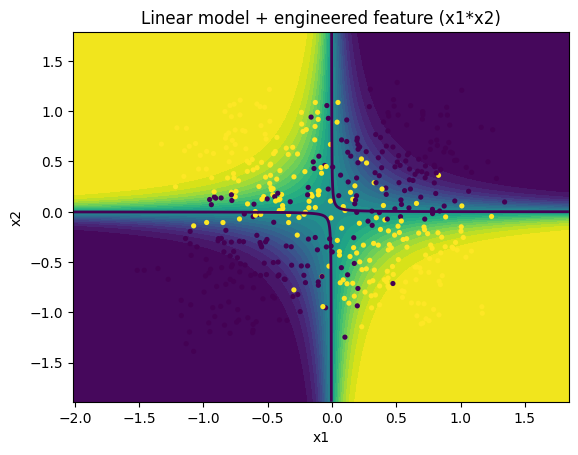

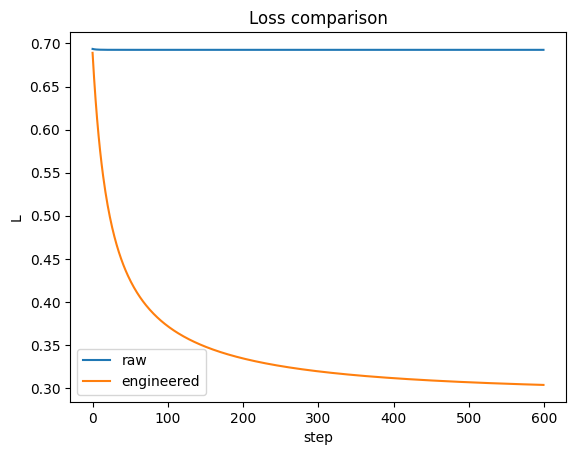

In [17]:
# Engineer a feature: x1*x2 (a minimal "representation" change)
x_eng = np.concatenate([x, (x[:,0:1] * x[:,1:2])], axis=1)
print('x_eng shape:', x_eng.shape)

W2, b2, losses2 = train_linear_logreg(x_eng, y, lr=0.8, steps=600)
print('Final loss (engineered feature):', losses2[-1])

plot_decision_boundary_linear(x, y, W2, b2,
                                'Linear model + engineered feature (x1*x2)',
                                use_grid_product=True,
                                plot_decision_boundary=True)

plt.figure()
plt.plot(losses, label='raw')
plt.plot(losses2, label='engineered')
plt.title('Loss comparison')
plt.xlabel('step')
plt.ylabel('L')
plt.legend()
plt.show()

## Reflection questions
1. What exactly failed on XOR: optimization, representation, or both?
2. Why did adding `x1*x2` help a linear model?
3. In real problems, what is the analogue of “engineering a feature” vs “learning features”?
4. When would you prefer a simpler model even if a neural net could fit?
5. What signs suggest you should invest in better data/labels instead of a bigger model?

## Optional extensions
1. Increase noise and observe when engineered features stop helping.
2. Try adding polynomial features up to degree 2 manually.
3. Measure accuracy for both models at threshold 0.5 and compare.